## COVID-19 Statistics

Simple repository to explore and show data about the new pandemic virus Corona Virus.

### Datasets

- World Data at: https://github.com/CSSEGISandData/COVID-19

- Brazil Data at: https://github.com/wcota/covid19br

- Brazil Population and other informations: https://www.ibge.gov.br/estatisticas/sociais/populacao.html

- World Population: https://www.worldometers.info/world-population/population-by-country/

- [Impact of non-pharmaceutical interventions (NPIs) to reduce COVID-19 mortality and healthcare demand](https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf)

- [Vital Surveillances: The Epidemiological Characteristics of an Outbreak of 2019 Novel Coronavirus Diseases (COVID-19) — China, 2020](http://weekly.chinacdc.cn/en/article/id/e53946e2-c6c4-41e9-9a9b-fea8db1a8f51)


### Running notebook

In case you are running the notebook, do not forget to give a:

```bash
$> pip install -r requirements.txt
```

Download Firefox webdriver from https://github.com/mozilla/geckodriver/releases/tag/v0.26.0 to save the heatmap at the end.

### Statistics

#### 1. World data

In [1]:
from os import path, remove, popen
import datetime
import calendar
from multiprocessing import cpu_count
from concurrent.futures import ThreadPoolExecutor

import requests
import numpy as np
from scipy.stats import norm
from scipy.optimize import curve_fit, minimize
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import folium
from folium.plugins import HeatMap

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_log_error
from sklearn.preprocessing import StandardScaler

import os
import time
import warnings
from selenium import webdriver
from IPython.display import Image

# Saving image using Firefox driver NO WINDOW MODE
os.environ["MOZ_HEADLESS"] = "1"

warnings.filterwarnings('ignore')
np.seterr(all="ignore")

%matplotlib inline

data_atual = datetime.datetime.now()
print(f"Last run: {data_atual}")
data_atual = datetime.datetime.now().strftime("%Y-%m-%d")

Last run: 2021-01-22 13:10:48.648656


In [61]:
def save_map_and_load(m, mapname="world_map"):
    delay = 2
    mappath, mapfile = os.getcwd(), f"{mapname}.html"
    tmpurl = f"file://{mappath}/{mapfile}"
    m.save(mapfile)

    os_sys = os.popen('cat /etc/os-release').read()
    driver_path = f"{mappath}/driver/geckodriver"
    if "Raspbian" in os_sys:
        driver_path = f"{mappath}/driver/geckodriver-arm"

    browser = webdriver.Firefox(executable_path=driver_path)
    browser.get(tmpurl)
    time.sleep(delay)
    browser.save_screenshot(f"{mappath}/{mapname}.png")
    browser.quit()

    remove(mapfile)

    return Image(filename=f"{mappath}/{mapname}.png")


def correct_dataframe_data(df):
    df.rename(columns={"Country_Region": "Country", "Last_Update": "Last Update"}, inplace=True)
    df.rename(columns={"Country/Region": "Country", "Last_Update": "Last Update"}, inplace=True)
    df[["Confirmed", "Deaths", "Recovered"]] = df[["Confirmed", "Deaths", "Recovered"]].fillna(0)
    df[["Confirmed", "Deaths", "Recovered"]] = df[["Confirmed", "Deaths", "Recovered"]].astype(np.int)
    df["Country"] = df["Country"].str.replace("Mainland China", "China")
    df["Country"] = df["Country"].str.replace("Korea, South", "South Korea")
    df["Country"] = df["Country"].str.replace("Palestinian territory", "Palestinian")
    df["Country"] = df["Country"].str.replace("occupied Palestinian", "Palestinian")
    df["Country"] = df["Country"].str.replace("US", "United States")
    df["Country"] = df["Country"].str.replace("UK", "United Kingdom")
    df["Country"] = df["Country"].str.replace("*", "")
    df["Country"] = df["Country"].str.replace("Czechia", "Czech Republic (Czechia)")
    df["Country"] = df["Country"].str.replace("Cote d'Ivoire", "Côte d'Ivoire")
    df["Country"] = df["Country"].str.replace("Saint Kitts and Nevis", "Saint Kitts & Nevis")
    df["Country"] = df["Country"].str.replace("Saint Vincent and the Grenadines", "St. Vincent & Grenadines")
    df["Country"] = df["Country"].str.replace(" \(Brazzaville\)", "")
    df["Country"] = df["Country"].str.replace(" \(Kinshasa\)", "")
    return df


def download(day):
    try:
        if day <= datetime.datetime.now().date():
            dt = day.strftime("%m-%d-%Y")
            url = f"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{dt}.csv"
            r = requests.get(url, timeout=10)
            if r.status_code == 200:
                with open(f"data/covid-19/world/{dt}.csv", "wb") as f:
                    f.write(r.content)
                return True
    except:
        pass
    return False

def download_brazil(filename, url):
    r = requests.get(url, timeout=10)
    if r.status_code == 200:
        with open(f"data/covid-19/brazil/{filename}.csv", "wb") as f:
            f.write(r.content)
        return True

def get_day(months, years=[2020, 2021]):
    days = []
    for month in months:
        for year in years:
            num_days = calendar.monthrange(year, month)[1]
            days += [datetime.date(year, month, day) for day in range(1, num_days+1)]
    return days


# If set value of c = 1 we extrapolat for the use of 1% formula
def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-(x - b) / a))

def exponential(x, a, b, c):
    return a * np.exp(b * (x - c))

def predict_curve(data, days=25):
    plt.figure(figsize=(16, 22))
    for i, dat in enumerate(data):
        country, confirmed, population, urban_pop = dat
        mmax = np.ceil((population * urban_pop) * 0.01)
        ydata = confirmed / mmax
        size = len(confirmed)
        fromm = int(size / 2)
        xdata = np.asarray(range(size))

        p0 = (1, 1, 1)
        popt, pcov = curve_fit(sigmoid, xdata, ydata, p0, maxfev=7500)
        x = np.arange(size + days)
        y = sigmoid(x, *popt) * mmax

        p0 = (1, 1, 1)
        popt, pcov = curve_fit(exponential, xdata, ydata, p0, maxfev=7500)
        x2 = np.arange(size + days)
        y2 = exponential(x2, *popt) * mmax

        ax = plt.subplot(5, 3, i + 1)
        plt.title(f"Country prediction: {country}")
        plt.plot([size, size], [0, np.max(y2)], "--", color="#aaa", label="extrapolation")
        plt.plot(xdata[fromm:], ydata[fromm:] * mmax, "o", label="data")
        plt.plot(x[fromm:], y[fromm:], label="sigmoid", color="C1")
        plt.plot(x2[fromm:], y2[fromm:], label="exponential", color="C3")

        plt.ylabel("Confirmed cases")
        plt.xlabel("Days since first case")
        plt.legend(loc="best")
    plt.minorticks_on()
    plt.grid(b=True, color='#aaa', linestyle='-', alpha=0.2)
    plt.tight_layout()
    plt.show()

def sigmoid_extrapolation_mortality(ydata, max_cases):
    plt.figure(figsize=(14, 5))
    for i, mcase in enumerate(max_cases):
        title, case = mcase
        size = len(ydata)
        middle = int(len(ydata) / 2)
        mmax = middle + int(middle / 2)
        X = [0, middle, middle*2]
        Y = [0, case, case*3]

        p0 = (1, 1, 1)
        popt, pcov = curve_fit(sigmoid, X, Y, p0, maxfev=7500)
        x2 = np.linspace(0, 3, 100)
        y2 = sigmoid(x2, *popt)
        
        plt.subplot(1, 2, i + 1)
        plt.title(f"Given {title} mortality rate, \n and middle point of S-Curve being {case} infected people.")
        plt.plot(ydata, color="C3", label="Official")
        plt.plot(x2*middle, y2, color="C0", label="Extrapolation")
        plt.plot(np.arange(size*2), np.tile(case, size*2), "--", color="C4", label=f"{case}")
        plt.plot(np.arange(size*2), np.tile(ydata[-1], size*2), "--", color="C2", label=f"{ydata[-1]}")
        plt.legend()
        plt.xlabel("Days")
        plt.ylabel("Confirmed Cases")
    plt.tight_layout()
    plt.show()

In [62]:
days = get_day([1, 2, 3])
with ThreadPoolExecutor(max_workers=cpu_count() * 2) as exc:
    rs = exc.map(download, days)
# print(list(rs))

In [100]:
a = download_brazil(f"cases-brazil-total-{data_atual}", "https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-total.csv")
a = download_brazil(f"cases-brazil-cities-{data_atual}", "https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-cities.csv")
# Need to do manual download... file too big
# a = download_brazil(f"cases-brazil-cities-time-{data_atual}", "https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-cities-time.csv")

In [64]:
days = get_day([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

df = None
for day in reversed(days):
    dt = day.strftime("%m-%d-%Y")
    filename = f"data/covid-19/world/{dt}.csv"
    if os.path.isfile(filename):
        df = pd.read_csv(filename)
        break

df = correct_dataframe_data(df)

df = pd.DataFrame(pd.pivot_table(
    df,
    values=["Confirmed", "Deaths", "Recovered"],
    index=["Country"],
    aggfunc=np.sum
)).reset_index()

In [65]:
wp = pd.read_csv("data/world_population.csv")
wp = wp[["Country (or dependency)", "Population\n(2020)", "Density\n(P/Km²)", "Urban\nPop %"]]
wp["Country (or dependency)"] = wp["Country (or dependency)"].str.strip()
wp["Urban\nPop %"] = wp["Urban\nPop %"].str.replace("%", "")
wp["Urban\nPop %"] = wp["Urban\nPop %"].str.replace("N.A.", "0")
wp["Urban\nPop %"] = wp["Urban\nPop %"].astype(np.int) / 100

columns = np.zeros((len(df), 3))
i = 0
for idx, row in df.iterrows():
    dados_wp = wp[wp["Country (or dependency)"] == row["Country"]]
    items = dados_wp[["Population\n(2020)", "Density\n(P/Km²)", "Urban\nPop %"]].to_numpy()
    if len(items) > 0:
        columns[i, :] = items[0]
    i += 1

df["Mortality %"] = round((df["Deaths"] / df["Confirmed"]) * 100, 2)
df["Population"] = columns[:, 0].astype(np.int)
df["Density/Pop"] = columns[:, 1].astype(np.int)
df["Urban/Pop %"] = columns[:, 2]
df["Mortality/Pop %"] = round((df["Deaths"] / df["Population"]) * 100, 5)

In [66]:
print("-" * 20)
print("Confirmed cases stats:")
print("-" * 20)
print("Mortality Rate :", round((df["Deaths"].sum() / df["Confirmed"].sum()) * 100, 2), "%")
print("Recovered Rate :", round((df["Recovered"].sum() / df["Confirmed"].sum()) * 100, 2), "%")
print("Confirmed Cases:", df["Confirmed"].sum())
print("Recovered      :", df["Recovered"].sum())
print("Total Death    :", df["Deaths"].sum())
print()

print("-" * 20)
print("World Population stats:")
print("-" * 20)
print("Confirmed Cases:", round((df["Confirmed"].sum() / df["Population"].sum()) * 100, 5), "%")
print("Mortality Rate :", round((df["Deaths"].sum() / df["Population"].sum()) * 100, 5), "%")

--------------------
Confirmed cases stats:
--------------------
Mortality Rate : 2.18 %
Recovered Rate : 56.31 %
Confirmed Cases: 83488443
Recovered      : 47010049
Total Death    : 1818336

--------------------
World Population stats:
--------------------
Confirmed Cases: 1.09925 %
Mortality Rate : 0.02394 %


In [68]:
df2 = df.sort_values(by=["Deaths"], ascending=False)
print(df2.head(20).to_string(index=False))

       Country  Confirmed  Deaths  Recovered  Mortality %  Population  Density/Pop  Urban/Pop %  Mortality/Pop %
 United States   20032035  345955          0         1.73   331002651           36         0.83          0.10452
        Brazil    7675973  194949    6848844         2.54   210147125           25         0.88          0.09277
         India   10266674  148738    9860280         1.45  1380004385          464         0.35          0.01078
        Mexico    1426094  125807    1074795         8.82   128932753           66         0.84          0.09758
         Italy    2107166   74159    1463111         3.52    60461826          206         0.69          0.12265
United Kingdom    2496231   73622       5479         2.95    67886011          281         0.83          0.10845
        France    2677666   64759     200142         2.42    65273511          119         0.82          0.09921
        Russia    3127347   56271    2527722         1.80   145934462            9         0.74 

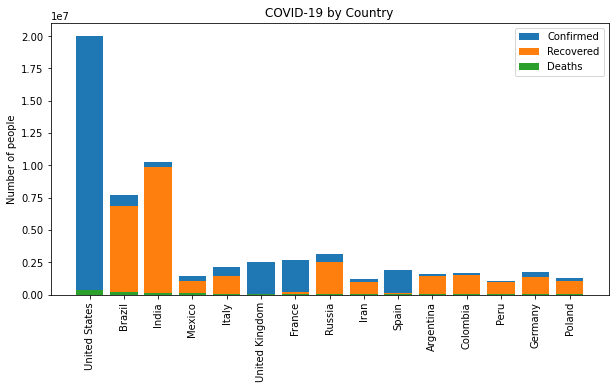

In [70]:
N = 15
plt.figure(figsize=(10, 5))
plt.title("COVID-19 by Country")
plt.bar(df2["Country"][:N], df2["Confirmed"][:N], label="Confirmed")
plt.bar(df2["Country"][:N], df2["Recovered"][:N], label="Recovered")
plt.bar(df2["Country"][:N], df2["Deaths"][:N], label="Deaths")
plt.xticks(rotation=90)
plt.ylabel("Number of people")
plt.legend()
plt.show()

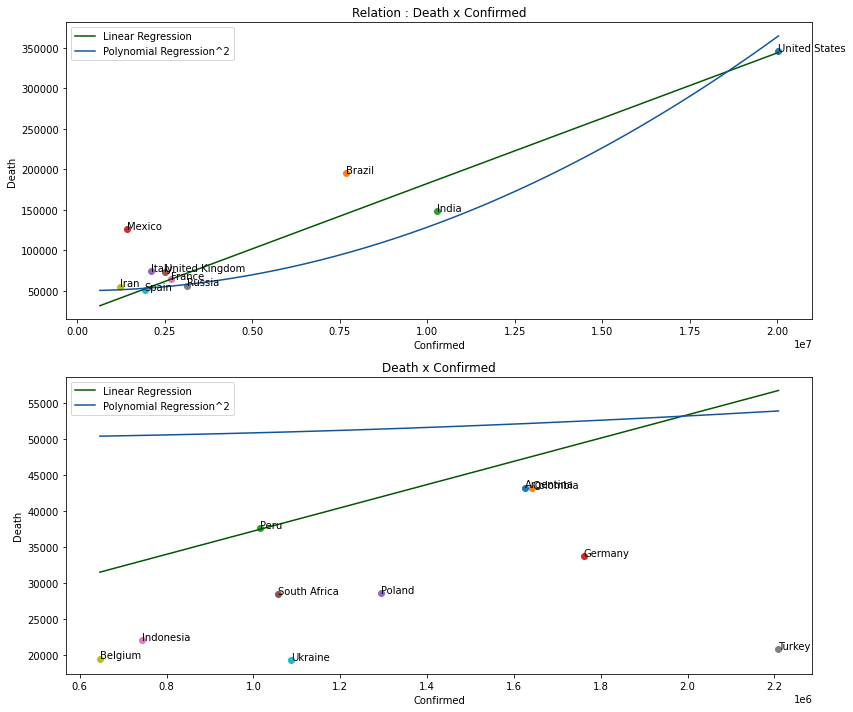

In [71]:
K = 20
df3 = df2.head(K)

scaler = StandardScaler()

countries, confirmed, death = df3["Country"].to_numpy(), df3["Confirmed"].to_numpy(), df3["Deaths"].to_numpy()

cmin = np.min(confirmed)
cmax = np.max(confirmed) + 1000
dmax = np.max(death)

X, y = confirmed, death

range_item = np.array(range(cmin, cmax, 1000)).reshape(-1, 1)

model = make_pipeline(Ridge(solver="lsqr"))
model.fit(X.reshape(-1, 1), y)
linear = model.predict(range_item)

model = make_pipeline(PolynomialFeatures(2), Ridge(solver="lsqr"))
model.fit(X.reshape(-1, 1), y)
polynomial = model.predict(range_item)

plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
for idx, country in enumerate(countries[:10]):
    plt.scatter(X[idx], y[idx], c=f"C{idx}")
    plt.annotate(country, (X[idx], y[idx]))
plt.title("Relation : Death x Confirmed")
plt.plot(range_item[:cmax], linear, c="#050", label="Linear Regression")
plt.plot(range_item[:cmax], polynomial, c="#159", label="Polynomial Regression^2")
plt.xlabel("Confirmed")
plt.ylabel("Death")
plt.legend()

cmax = 0
plt.subplot(2, 1, 2)
for idx, country in enumerate(countries[10:]):
    idx = idx + 10
    if cmax < X[idx]:
        cmax = X[idx]
    plt.scatter(X[idx], y[idx], c=f"C{idx}")
    plt.annotate(country, (X[idx], y[idx]))
range_item = np.array(range(cmin, cmax + 1000, 1000)).reshape(-1, 1)
plt.title("Death x Confirmed")
plt.plot(range_item, linear[:len(range_item)], c="#050", label="Linear Regression")
plt.plot(range_item, polynomial[:len(range_item)], c="#159", label="Polynomial Regression^2")
plt.xlabel("Confirmed")
plt.ylabel("Death")
plt.legend()

plt.tight_layout()
plt.show()

---

The bellow graphics show the evolution of the desease over time for some countries.

In [72]:
li = []
for day in reversed(days):
    dt = day.strftime("%m-%d-%Y")
    filename = f"data/covid-19/world/{dt}.csv"
    if os.path.isfile(filename):
        df_ = pd.read_csv(filename, index_col=None, header=0)
        df_.rename(columns={"Country_Region": "Country/Region", "Last_Update": "Last Update"}, inplace=True)
        df_[["Last Update"]] = pd.to_datetime(pd.to_datetime(dt).strftime("%d-%m-%Y"), format="%d-%m-%Y")
        # df_[["Last Update"]] = df_[["Last Update"]].apply(lambda x: pd.to_datetime(pd.to_datetime(x).dt.strftime("%d-%m-%Y"), format="%d-%m-%Y"))
        li.append(df_)
df = pd.concat(li, axis=0, ignore_index=True).sort_values(by=["Last Update", "Country/Region"])

df = correct_dataframe_data(df)
df_t = df.copy()

df = pd.DataFrame(pd.pivot_table(
    df,
    values=["Confirmed", "Deaths", "Recovered"],
    index=["Country", "Last Update"],
    aggfunc=np.sum
)).reset_index().sort_values(by=["Last Update", "Country"])
df["Mortality %"] = round((df["Deaths"] / df["Confirmed"]) * 100, 2)

df_extrapolation = df.copy(deep=True)

# df[df["Country/Region"] == "US"]

In [73]:
countries = [
    "Brazil", "Chile", "Argentina", 
    "United States", "Canada", "Australia",
    "Spain", "France", "Italy", 
    "Iran", "South Korea", "Japan", 
    "Sweden", "Ecuador", "China"]

In [76]:
def print_graphic_for_country(df, countries, dtype="Confirmed", log=False):
    fig = plt.figure(figsize=(14, 20))
    # fig.autofmt_xdate()
    for i, country in enumerate(countries):
        data = df[df["Country"] == country]
        data["Last Update"] = data["Last Update"].dt.strftime("%Y-%m-%d")
        data = data.to_numpy()
        times = pd.date_range(data[:, 1][0], periods=250, freq='30min')

        ax = plt.subplot(5, 3, i + 1)
        if dtype == "Confirmed":
            dados = data[:, 2]
            if log:
                dados = np.log(dados.astype(np.float) + 1e-20)
                dados[dados < 0] = 0
                plt.title(f"Contamination for {country} (Logarithmic Scale)")
                color = "C4"
            else:
                plt.title(f"Contamination for {country}")
                color = "C1"
            plt.plot(range(0, len(dados)), dados, "o", color="black")
            plt.fill_between(range(0, len(dados)), dados.astype(np.float), label="Confirmed", color=color)
            plt.ylabel("Confirmed")
            plt.xlabel("Data")
        elif dtype == "Death":
            dados = data[:, 3]
            plt.plot(range(0, len(data[:, 1])), dados, "o", color="black")
            plt.fill_between(range(0, len(data[:, 1])), dados.astype(np.float), label="Death", color="C3")
            plt.title(f"Death counts for {country}")
            plt.ylabel("Death")
            plt.xlabel("Data")
        elif dtype == "Recovered":
            dados = data[:, 4]
            plt.plot(range(0, len(data[:, 1])), dados, "o", color="black")
            plt.fill_between(range(0, len(data[:, 1])), dados.astype(np.float), label="Recovered", color="C2")
            plt.title(f"Recovered for {country}")
            plt.ylabel("Recovered")
            plt.xlabel("Data")
        elif dtype == "Mortality %":
            dados = data[:, 5]
            plt.plot(range(0, len(data[:, 1])), dados, "o", color="black")
            plt.fill_between(range(0, len(data[:, 1])), dados.astype(np.float), label="Mortality %", color="C5")
            plt.title(f"Mortality % for {country}")
            plt.ylabel("Mortality %")
            plt.xlabel("Data")
        skip = 30
        plt.xticks(np.arange(len(dados), step=skip), data[:, 1][::skip])
        plt.xticks(rotation=45)
        plt.minorticks_on()
        plt.grid(b=True, color='#aaa', linestyle='-', alpha=0.2)
        plt.legend()

    plt.tight_layout()
    plt.show()

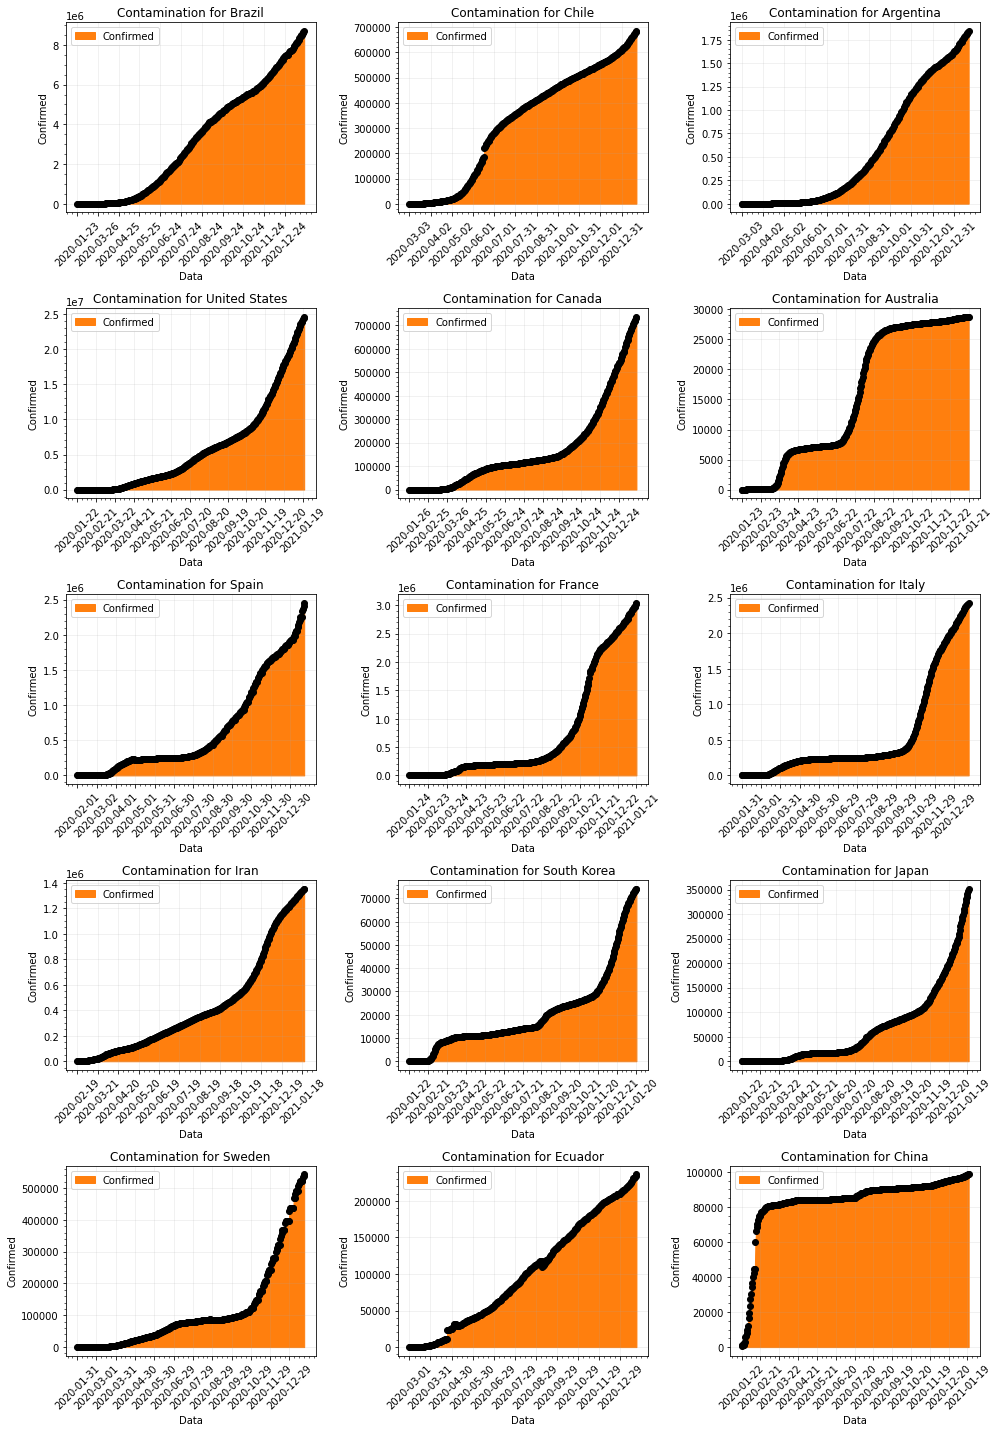

In [77]:
print_graphic_for_country(df, countries)

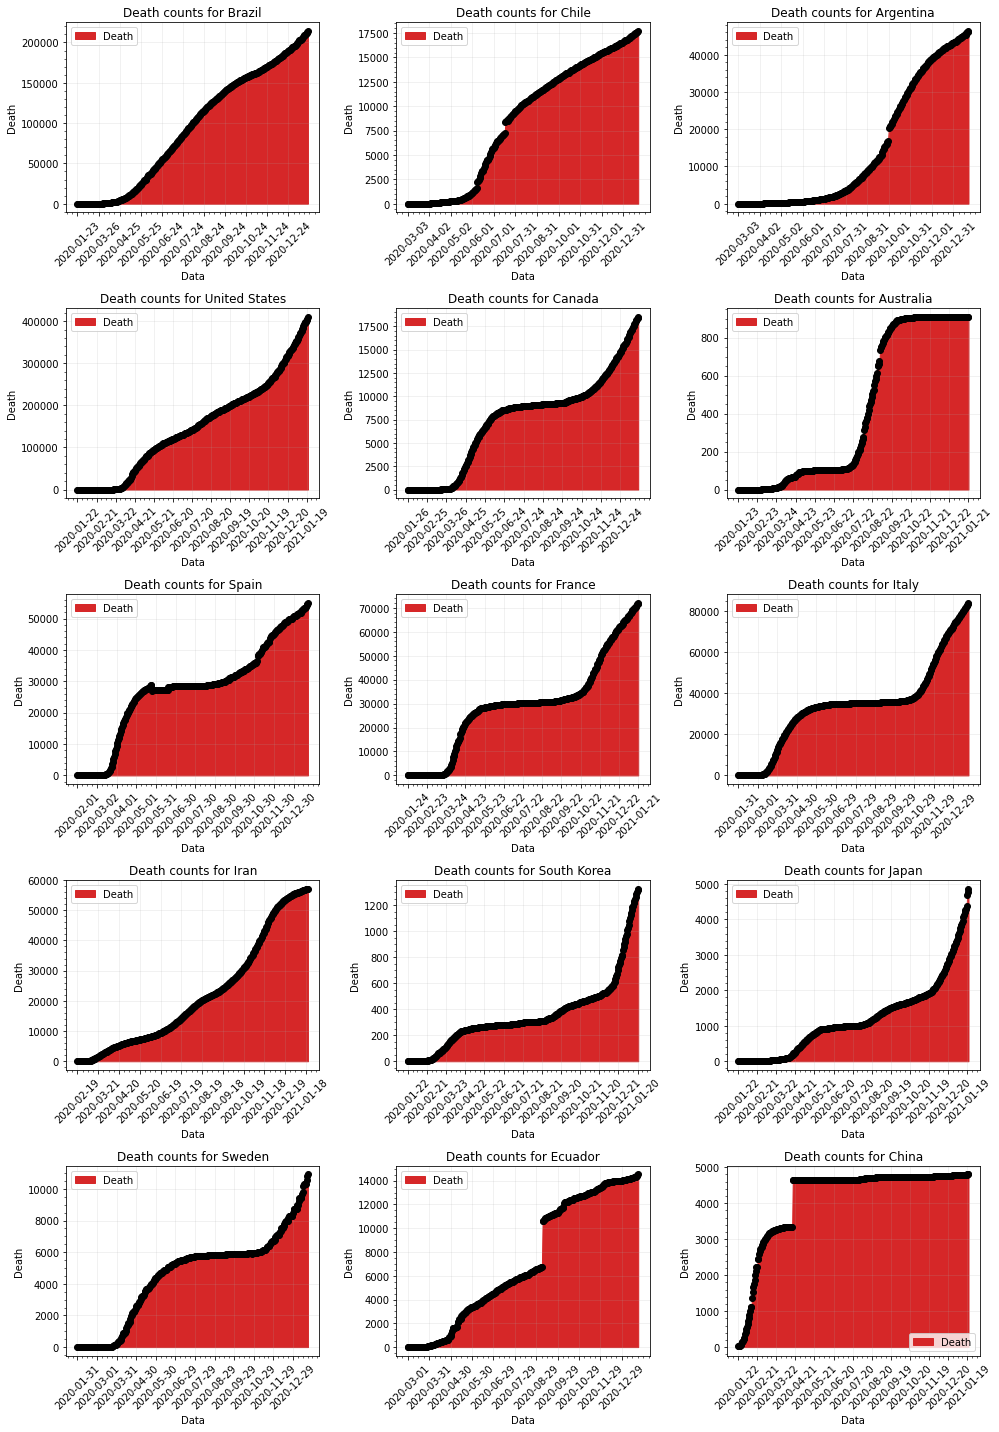

In [78]:
print_graphic_for_country(df, countries, "Death")

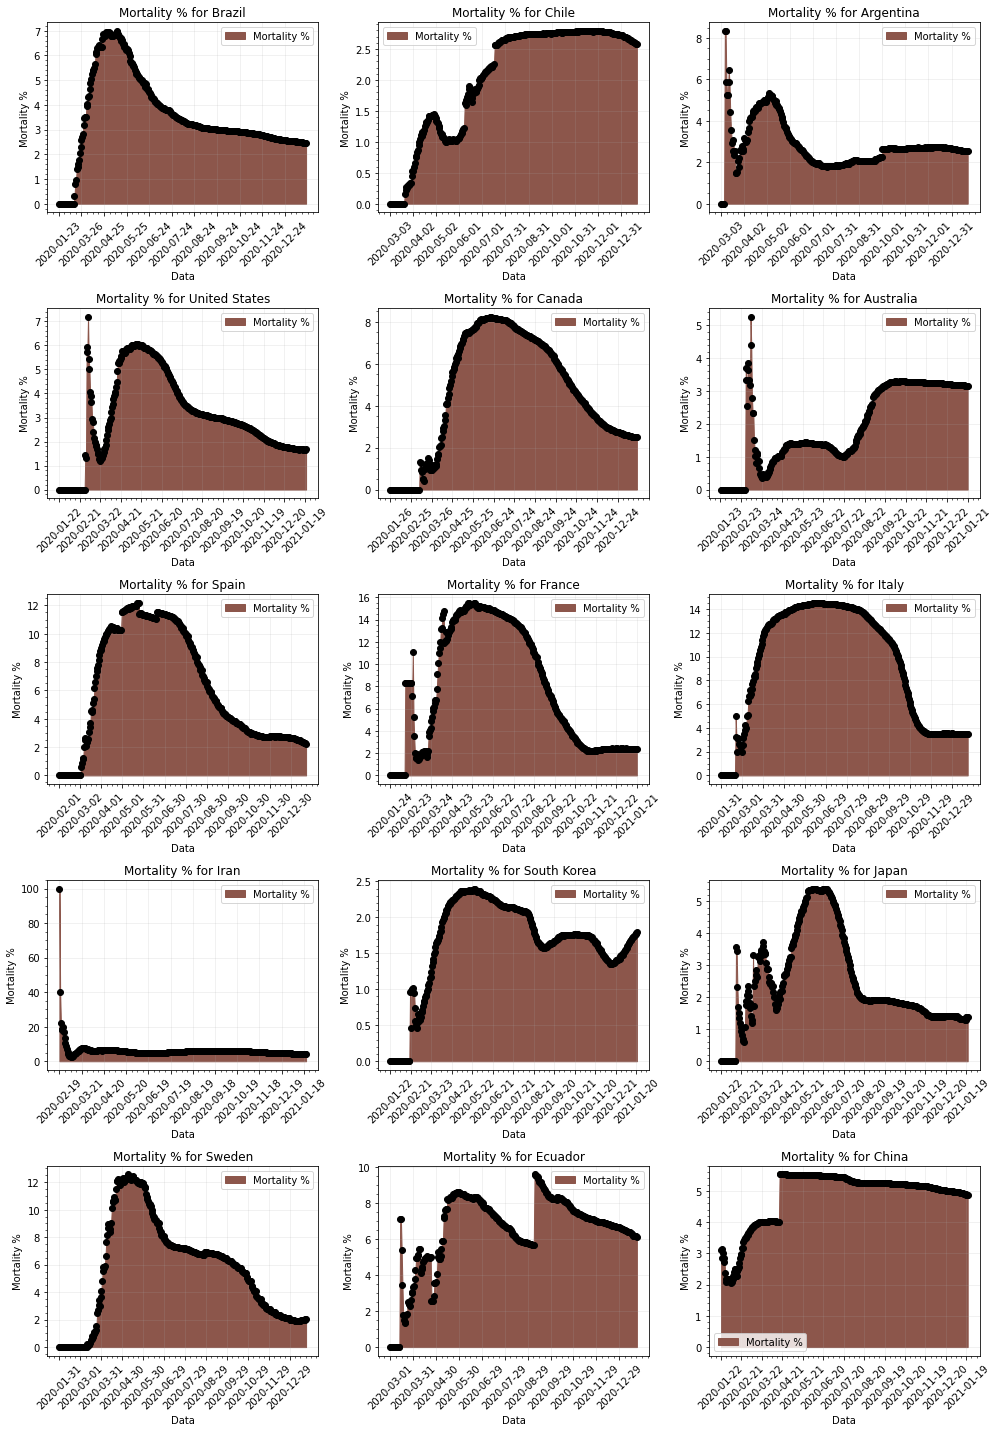

In [79]:
print_graphic_for_country(df, countries, "Mortality %")

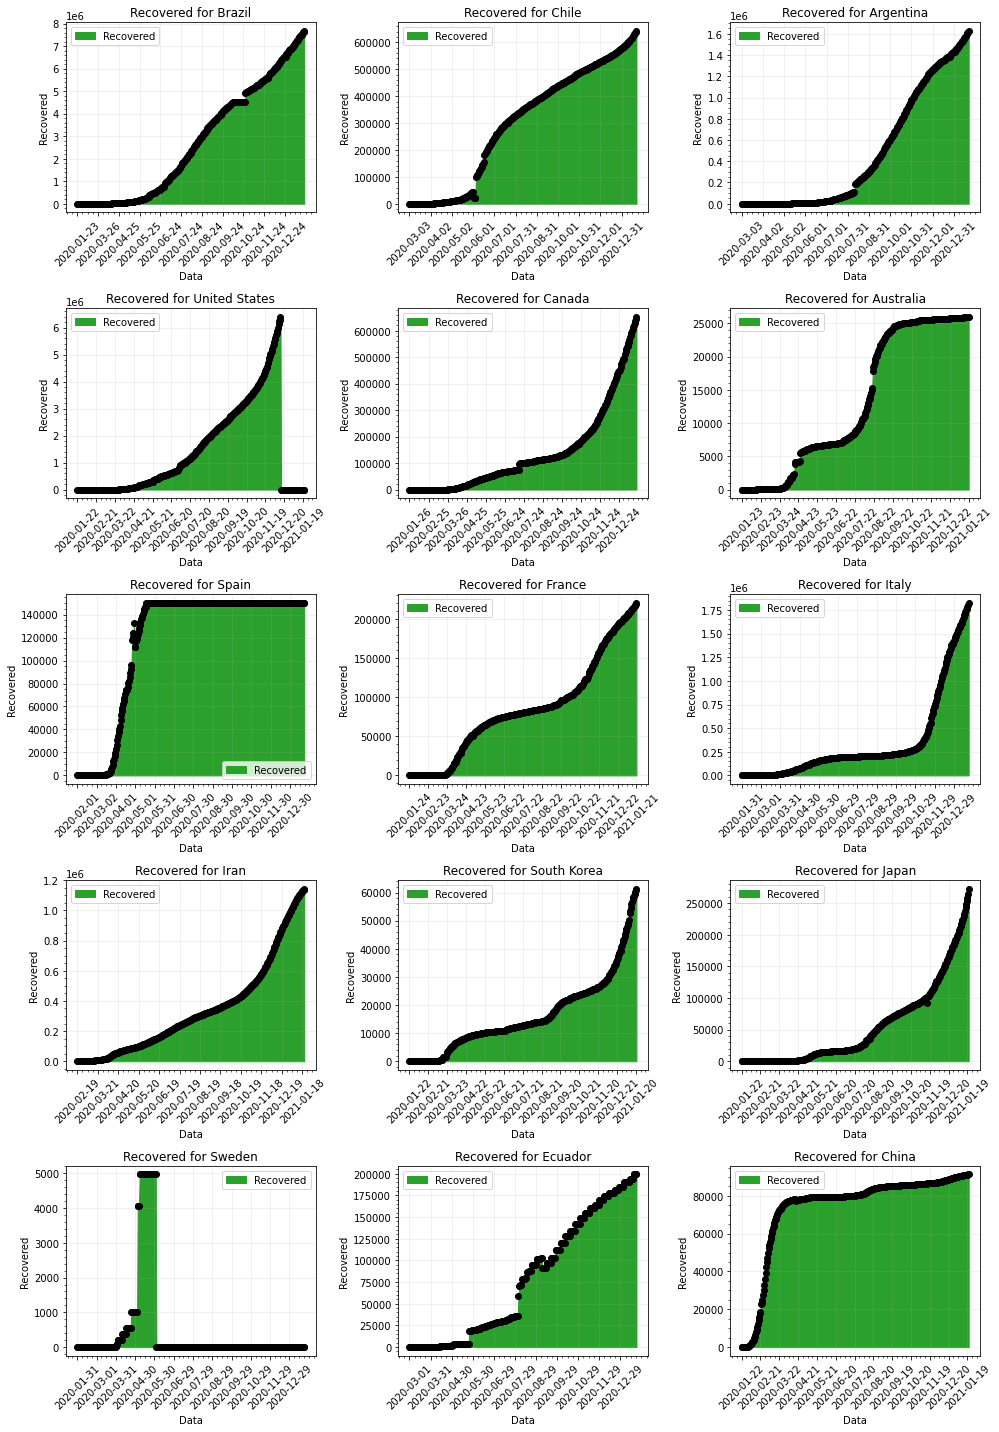

In [80]:
print_graphic_for_country(df, countries, "Recovered")

#### Logarithmic Scale

Bellow some graphics in log scale of Confirmed cases for the above countries.

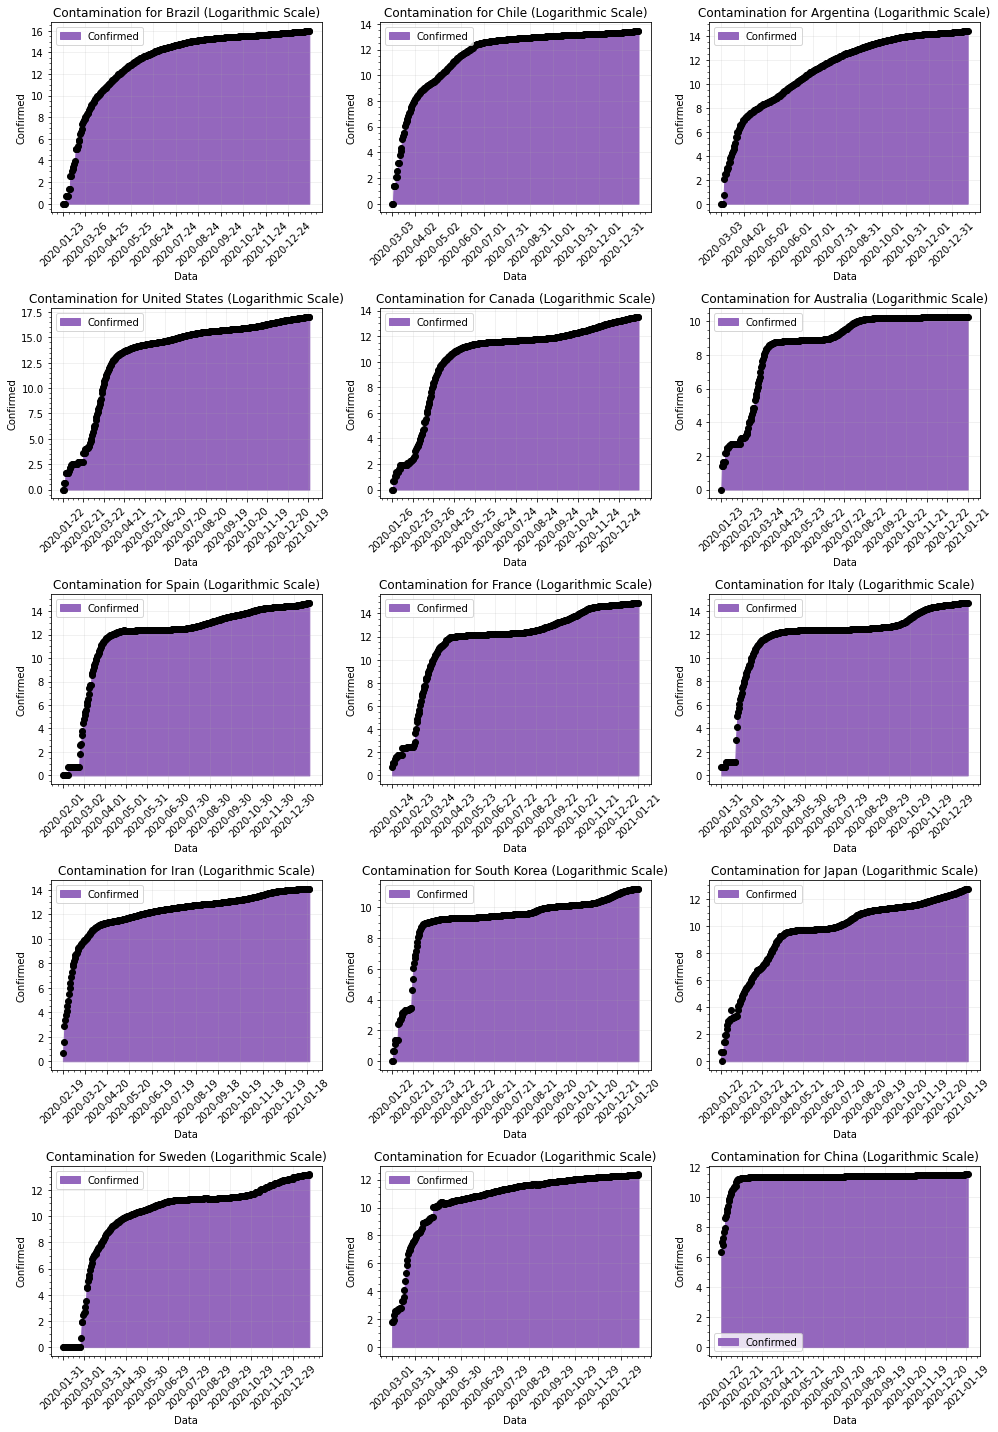

In [81]:
print_graphic_for_country(df, countries, log=True)

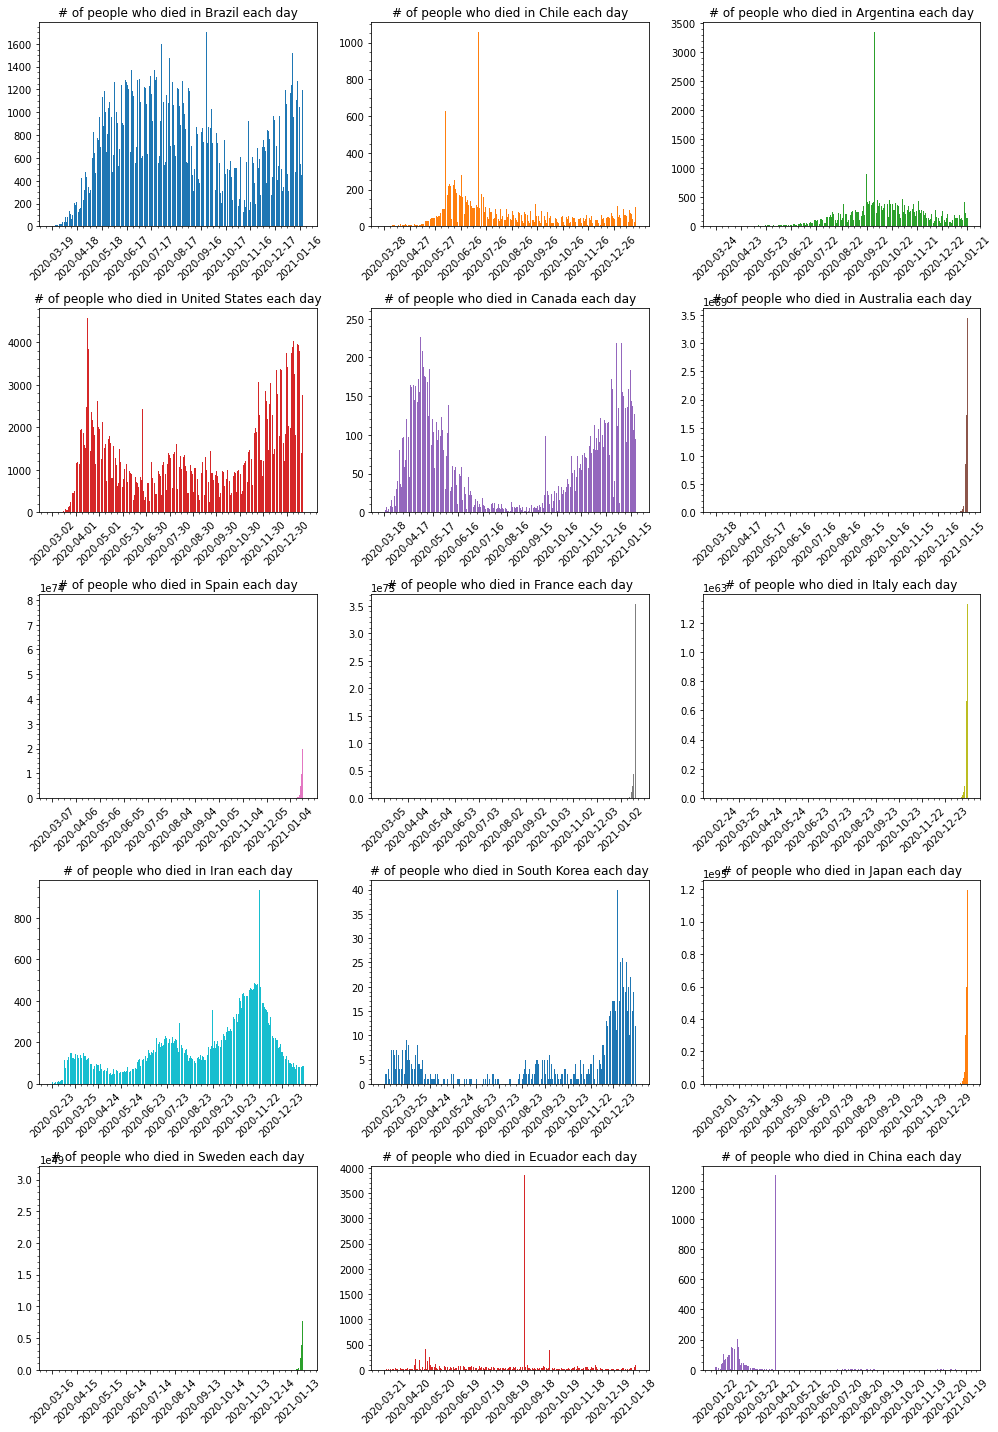

In [84]:
def print_graphic_country_death_by_day(df, countries, min_death=5):
    fig = plt.figure(figsize=(14, 20))
    for i, country in enumerate(countries):
        ax = plt.subplot(5, 3, i + 1)
        data = df[df["Country"] == country]
        
        start_count, start_pos = False, 0
        mortos = []
        for death in data["Deaths"]:
            if death > min_death:
                start_count = True
            if start_count:
                mortos.append(abs(sum(mortos) - death))
            else:
                start_pos += 1
        dt = data["Last Update"][start_pos:]
        plt.title(f"# of people who died in {country} each day")
        plt.bar(dt.astype(str), mortos, color=f"C{i}")
        plt.xticks(np.arange(len(dt), step=30), dt[::30].astype(str))
        plt.xticks(rotation=45)
        plt.minorticks_on()
    plt.tight_layout()
    plt.show()

print_graphic_country_death_by_day(df, countries)

---

Predicting the pandemic of Corona Virus is hard, bellow is a simple demonstration of curve fitting, using 2 types (exponential and sigmoid) for estimation.

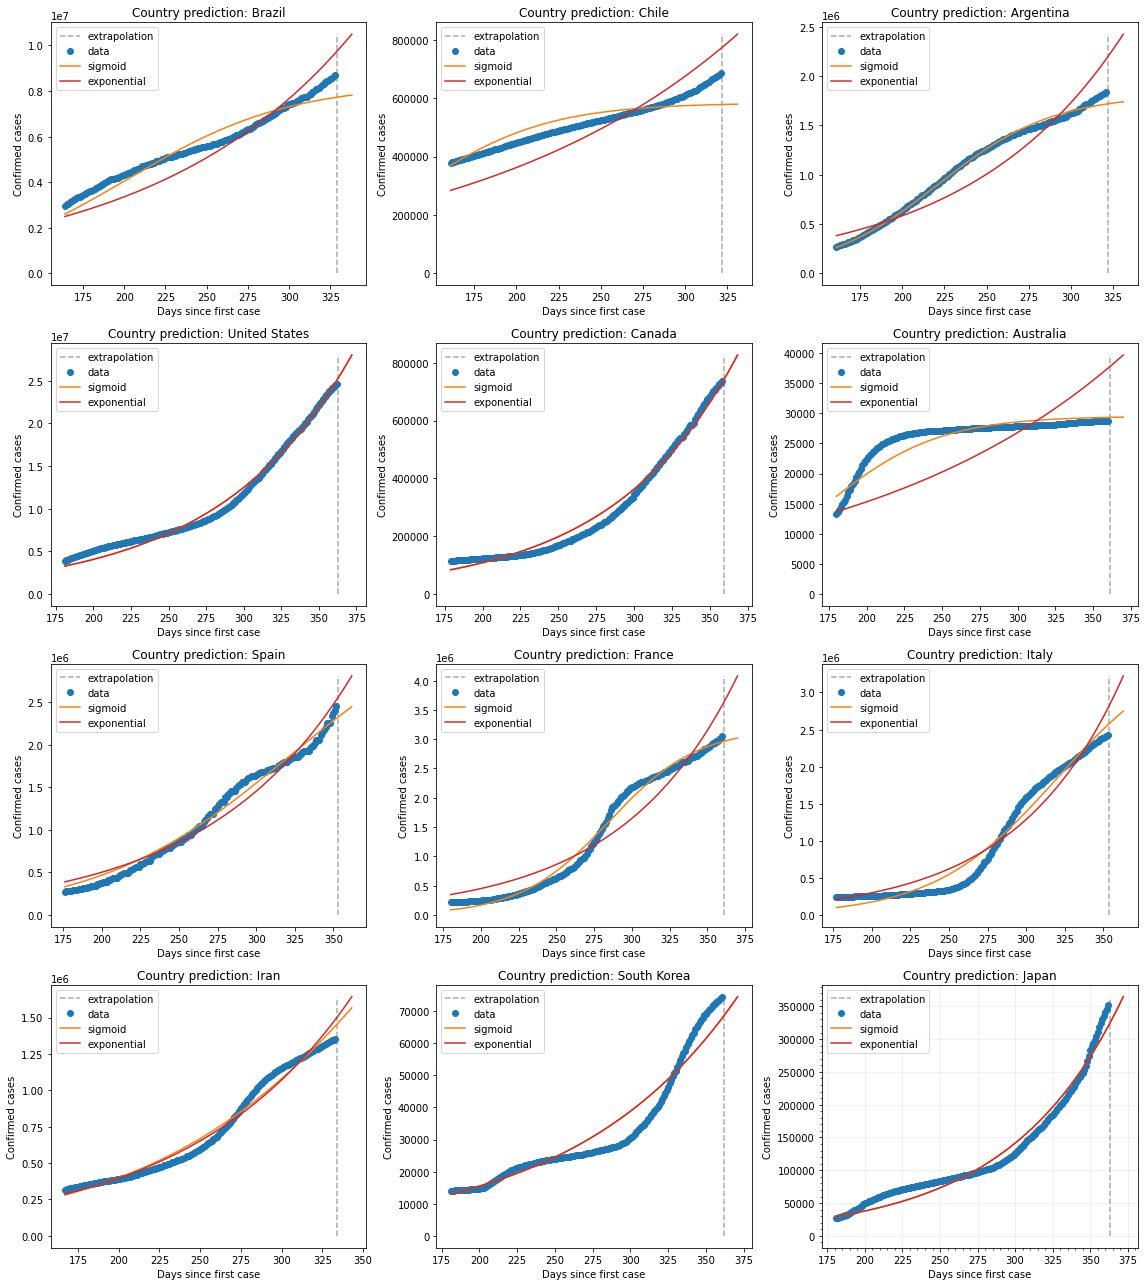

In [85]:
countries = [
    "Brazil", "Chile", "Argentina",
    "United States", "Canada", "Australia",
    "Spain", "France", "Italy",
    "Iran", "South Korea", "Japan"
]

data = []
for country in countries:
    pop = df2[df2["Country"] == country]["Population"].to_numpy()[0]
    ydata = df[df["Country"] == country]["Confirmed"].to_numpy()
    urban = df2[df2["Country"] == country]["Urban/Pop %"].to_numpy()[0]
    data.append([country, ydata, pop, urban])
predict_curve(data, days=10)

---

Another problem is not knowing the actual mortality for the disease.

The mortality for Covid-19 are said to be something like 3.8%, but previous calculations (based on data from China) put the mortality to be somthing like 2%... if this is truth, and looking at the mortality for Brazil, US and Italy, we should be able to extrapolate and calculate the possible real number of people who has the disease (been asyntomatic or not).

BRAZIL
--------------------
Taking into account 3.8%, means that it should have 5635447 cases.
Taking into account 2%, means that it should have 10707350 cases.


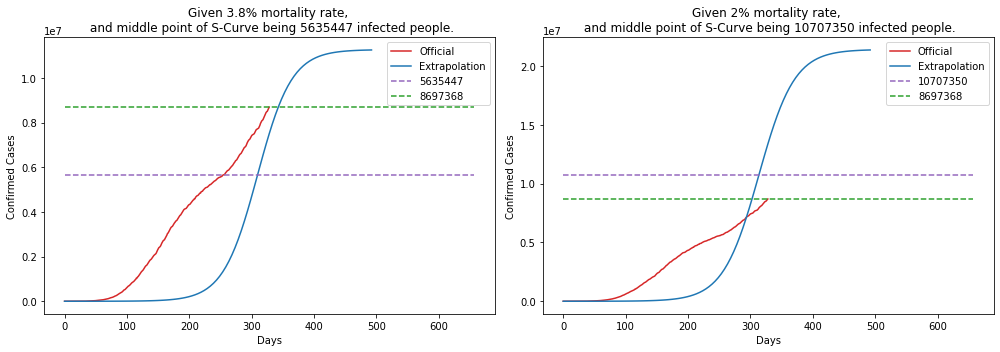

In [86]:
last_df_row = df_extrapolation[df_extrapolation["Country"] == "Brazil"].iloc[[-1]]
ydata = df_extrapolation[df_extrapolation["Country"] == "Brazil"]["Confirmed"].to_numpy()

deaths = last_df_row["Deaths"]
confirmed = last_df_row["Confirmed"]
mortality = (deaths / confirmed) * 100
cases_38 = int(deaths / (3.8 / 100))
cases_20 = int(deaths / (2 / 100))

print("BRAZIL")
print("-" * 20)
print(f"Taking into account 3.8%, means that it should have {cases_38} cases.")
print(f"Taking into account 2%, means that it should have {cases_20} cases.")
sigmoid_extrapolation_mortality(ydata, [("3.8%", cases_38), ("2%", cases_20)])

UNITED STATES
--------------------
Taking into account 3.8%, means that it should have 10792157 cases.
Taking into account 2%, means that it should have 20505100 cases.


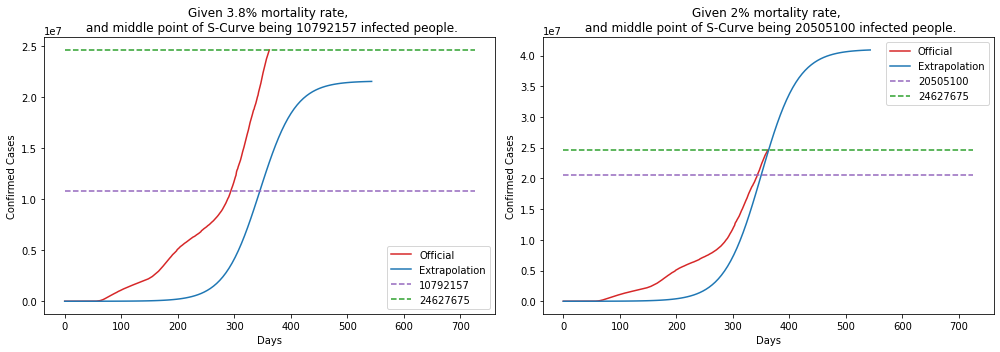

In [87]:
last_df_row = df_extrapolation[df_extrapolation["Country"] == "United States"].iloc[[-1]]
ydata = df_extrapolation[df_extrapolation["Country"] == "United States"]["Confirmed"].to_numpy()

deaths = last_df_row["Deaths"]
confirmed = last_df_row["Confirmed"]
mortality = (deaths / confirmed) * 100
cases_38 = int(deaths / (3.8 / 100))
cases_20 = int(deaths / (2 / 100))

print("UNITED STATES")
print("-" * 20)
print(f"Taking into account 3.8%, means that it should have {cases_38} cases.")
print(f"Taking into account 2%, means that it should have {cases_20} cases.")
sigmoid_extrapolation_mortality(ydata, [("3.8%", cases_38), ("2%", cases_20)])

ITALY
--------------------
Taking into account 3.8%, means that it should have 2215842 cases.
Taking into account 2%, means that it should have 4210100 cases.


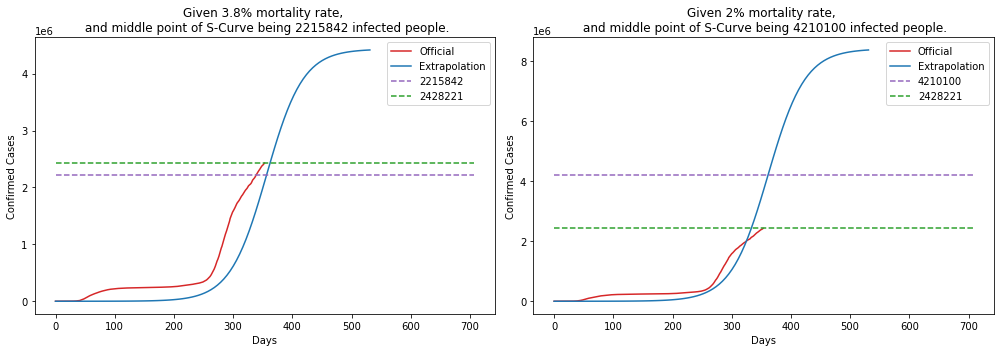

In [88]:
last_df_row = df_extrapolation[df_extrapolation["Country"] == "Italy"].iloc[[-1]]
ydata = df_extrapolation[df_extrapolation["Country"] == "Italy"]["Confirmed"].to_numpy()

deaths = last_df_row["Deaths"]
confirmed = last_df_row["Confirmed"]
mortality = (deaths / confirmed) * 100
cases_38 = int(deaths / (3.8 / 100))
cases_20 = int(deaths / (2 / 100))

print("ITALY")
print("-" * 20)
print(f"Taking into account 3.8%, means that it should have {cases_38} cases.")
print(f"Taking into account 2%, means that it should have {cases_20} cases.")

sigmoid_extrapolation_mortality(ydata, [("3.8%", cases_38), ("2%", cases_20)])

---

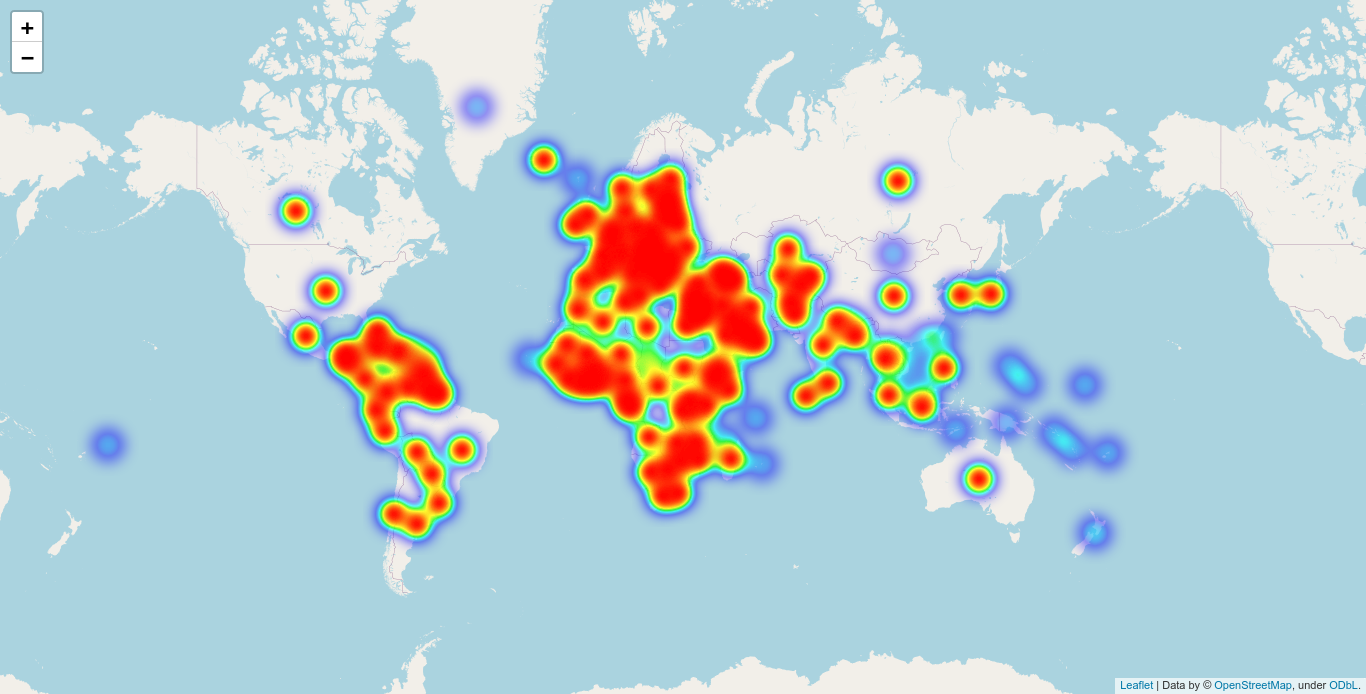

In [89]:
heatmap_data = []

countries = pd.read_csv("data/countries.csv")
for idx, row in countries.iterrows():
    data = df[df["Country"] == row["name"]].to_numpy()
    if len(data) > 0:
        last = data[-1]
        heatmap_data += [[row["latitude"], row["longitude"], last[2]]]

m = folium.Map(location=(20, 30), zoom_start=2.35)
heatmap = HeatMap(data=heatmap_data, min_opacity=0.5, radius=18, blur=13)
heatmap.add_to(m)
save_map_and_load(m)

#### 2. Cases for US

Simple compilation of cases in United States.

In [90]:
df = None
for day in reversed(days):
    dt = day.strftime("%m-%d-%Y")
    filename = f"data/covid-19/world/{dt}.csv"
    if path.isfile(filename):
        df = pd.read_csv(filename)
        break

df = correct_dataframe_data(df)

df_us = df[df["Country"] == "United States"]
df_us = pd.DataFrame(pd.pivot_table(
    df_us,
    values=["Confirmed", "Deaths"],
    index=["Province_State"],
    aggfunc=np.sum
)).reset_index()

df_us["Mortality %"] = round((df_us["Deaths"] / df_us["Confirmed"]) * 100, 2)

print(df_us.sort_values(by=["Confirmed"], ascending=False).head(10).to_string(index=False))

Province_State  Confirmed  Deaths  Mortality %
    California    2297039   25986         1.13
         Texas    1772784   28066         1.58
       Florida    1323315   21673         1.64
      New York     978783   37983         3.88
      Illinois     963389   17978         1.87
          Ohio     700380    8962         1.28
       Georgia     666452   10934         1.64
  Pennsylvania     645390   15947         2.47
     Tennessee     586802    6907         1.18
North Carolina     539545    6748         1.25


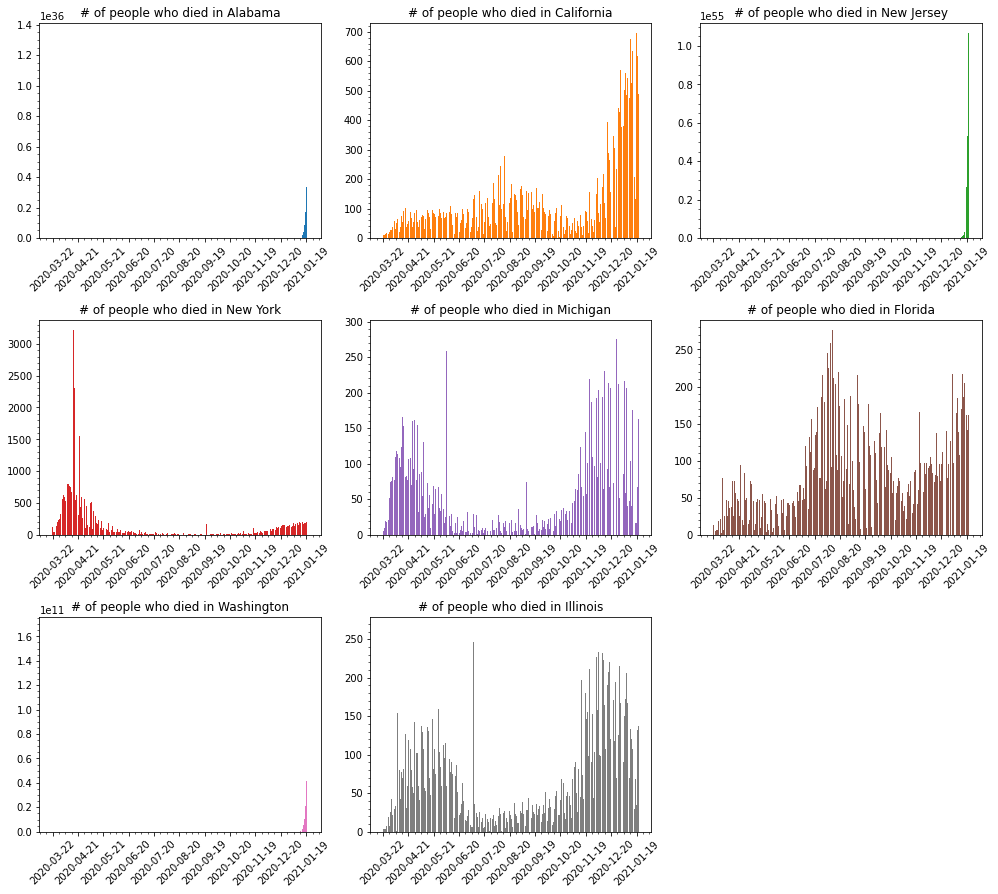

In [92]:
def print_graphic_for_us_state_death(df, states):
    fig = plt.figure(figsize=(14, 20))
    for i, state in enumerate(states):
        ax = plt.subplot(5, 3, i + 1)
        data = df[df["Province_State"] == state]
        mortos = []
        for death in data["Deaths"]:
            mortos.append(abs(sum(mortos) - death))
        plt.title(f"# of people who died in {state}")
        plt.bar(data["Last Update"].astype(str), mortos, color=f"C{i}")
        plt.xticks(np.arange(len(data["Last Update"]), step=30), data["Last Update"][::30].astype(str))
        plt.xticks(rotation=45)
        plt.minorticks_on()
    plt.tight_layout()
    plt.show()


df_li = []
for day in reversed(days):
    dt = day.strftime("%m-%d-%Y")
    filename = f"data/covid-19/world/{dt}.csv"
    if path.isfile(filename):
        df_ = pd.read_csv(filename, index_col=None, header=0)
        df_.rename(columns={"Country_Region": "Country/Region", "Last_Update": "Last Update"}, inplace=True)
        df_[["Last Update"]] = pd.to_datetime(pd.to_datetime(dt).strftime("%d-%m-%Y"), format="%d-%m-%Y")
        df_li.append(df_)
df_us_time = pd.concat(df_li, axis=0, ignore_index=True).sort_values(by=["Last Update", "Province_State"])
df_us_time = df_us_time[df_us_time["Country/Region"] == "US"].dropna(subset=["Province_State"], inplace=False)

df_us_time = pd.DataFrame(pd.pivot_table(
    df_us_time,
    values=["Deaths"],
    index=["Province_State", "Last Update"],
    aggfunc=np.sum
)).reset_index()

states = (
    "Alabama", "California", "New Jersey",
    "New York", "Michigan", "Florida",
    "Washington", "Illinois"
)
print_graphic_for_us_state_death(df_us_time, states)

---

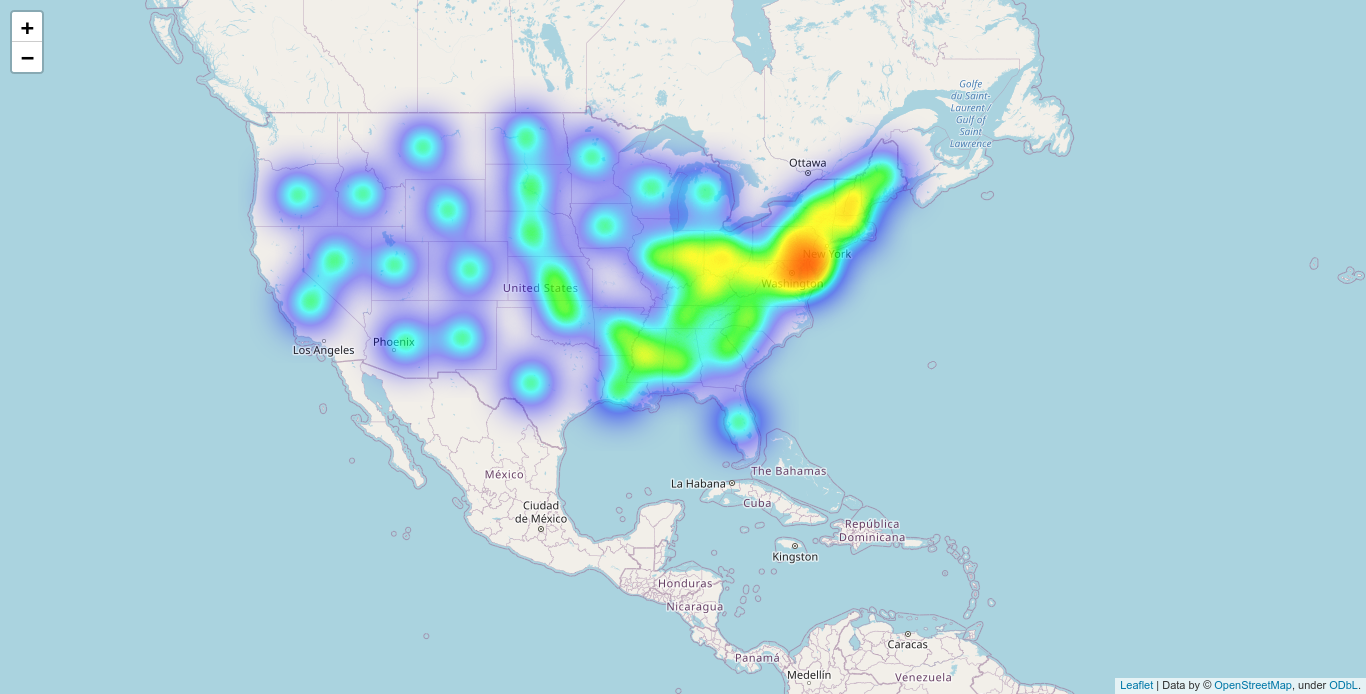

In [93]:
heatmap_data = []

us_states = pd.read_csv("data/us_states.csv")
for idx, row in us_states.iterrows():
    data = df_us[df_us["Province_State"] == row["State"]].to_numpy()
    if len(data) > 0:
        confirmed = data[0][1]
        heatmap_data += [[row["Latitude"], row["Longitude"], confirmed*12]]


m = folium.Map(location=(33.64566, -86.6836), zoom_start=4.45)
heatmap = HeatMap(data=heatmap_data, min_opacity=0.5, radius=25, blur=35)
heatmap.add_to(m)
save_map_and_load(m, mapname="us_map")

#### 3. Cases for Brazil

Simple compilation of cases in Brazil.

In [94]:
df_br_c = pd.read_csv(f"data/covid-19/brazil/cases-brazil-total-{data_atual}.csv")
df_br_c = df_br_c[["state", "totalCases", "deaths"]][1:].sort_values(by=["totalCases", "deaths"], ascending=False)
df_br_c.rename(columns={"state": "State", "totalCases": "Total Cases", "deaths": "Deaths"}, inplace=True)
df_br_c = df_br_c.sort_values(by=["State"]).reset_index()

df_br = pd.read_csv("data/brazil_states.csv")
df_br = df_br.sort_values(by=["Sigla"]).reset_index()
df_br["Total Cases"] = df_br_c["Total Cases"]
df_br["Deaths"] = df_br_c["Deaths"]
df_br["Mortality %"] = round((df_br["Deaths"] / df_br["Total Cases"]) * 100, 2)
df_br["Mortality/Pop %"] = round((df_br["Deaths"] / df_br["População"]) * 100, 5)
df_br.rename(columns={"População": "Population"}, inplace=True)

df_br.rename(columns={"Sigla": "State"}, inplace=True)
df_br = df_br.sort_values(by=["Total Cases"], ascending=False)

For the entire Brazil, as of today, we have the following numbers:

In [95]:
print("Mortality Rate     :", round((df_br["Deaths"].sum() / df_br["Total Cases"].sum()) * 100, 2), "%")
print("Total Death        :", df_br["Deaths"].sum())
print("Confirmed Cases    :", df_br["Total Cases"].sum())
print("Mortality Rate/Pop :", round((df_br["Deaths"].sum() / df_br["Population"].sum()) * 100, 5), "%")

Mortality Rate     : 2.46 %
Total Death        : 214317
Confirmed Cases    : 8704658
Mortality Rate/Pop : 0.10198 %


---

But, the story can't be told by the entire country, one must take into account, each state of the federation. Let's show data for each state in the federation.

In [96]:
presenter = df_br[
    ["UF", "Total Cases", "Deaths", "Mortality %", "Population", "Mortality/Pop %"]
].head(10).to_string(index=False)
print(presenter)

               UF  Total Cases  Deaths  Mortality %  Population  Mortality/Pop %
        São Paulo      1670754   50938         3.05    45919049          0.11093
     Minas Gerais       668216   13891         2.08    21168791          0.06562
            Bahia       553770    9760         1.76    14873064          0.06562
   Santa Catarina       552310    6036         1.09     7164788          0.08425
Rio Grande do Sul       520313   10196         1.96    11377239          0.08962
           Paraná       515464    9243         1.79    11433957          0.08084
   Rio de Janeiro       494127   28440         5.76    17264943          0.16473
            Ceará       359678   10299         2.86     9132078          0.11278
            Goiás       335665    7226         2.15     7018354          0.10296
             Pará       316176    7470         2.36     8602865          0.08683


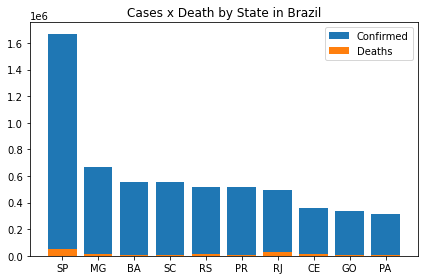

In [97]:
plt.figure(figsize=(6, 4))
plt.title("Cases x Death by State in Brazil")
plt.bar(df_br["State"][:10], df_br["Total Cases"][:10], label="Confirmed")
plt.bar(df_br["State"][:10], df_br["Deaths"][:10], label="Deaths")
plt.legend()
plt.tight_layout()
plt.show()

Each state tells a different story, but what about the **capitals** for some of those states?

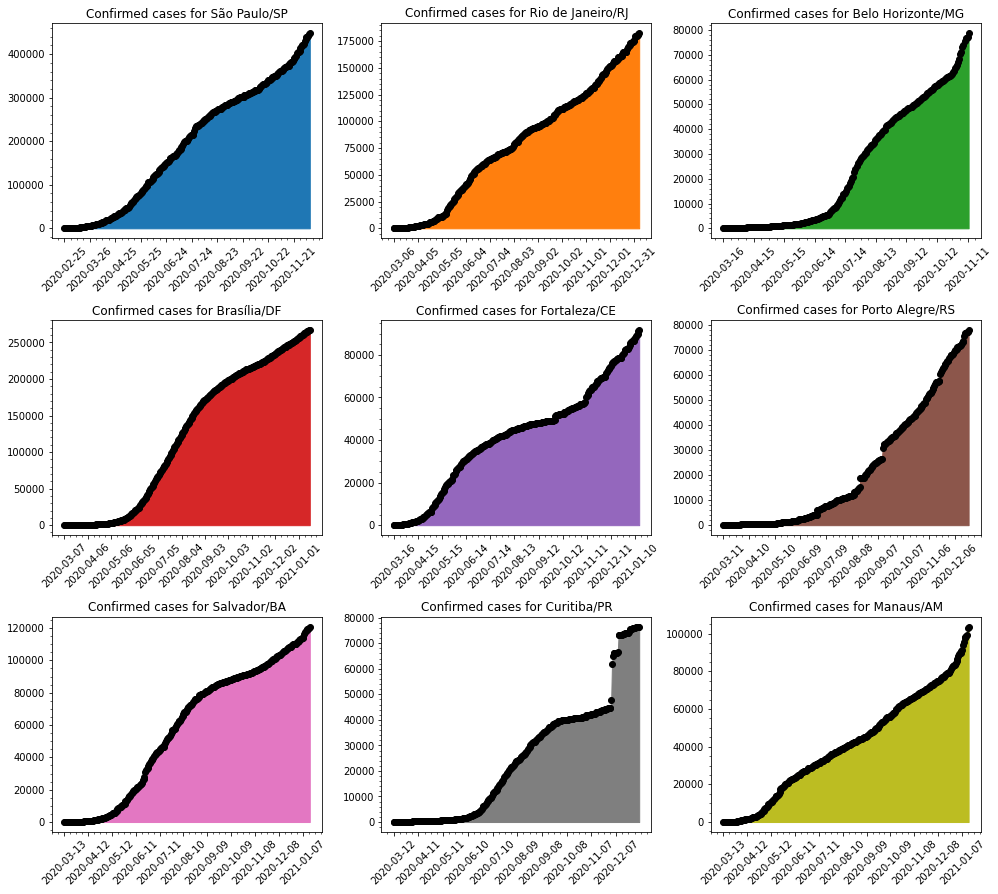

In [114]:
def print_graphic_for_brazil_city(df, cities):
    fig = plt.figure(figsize=(14, 20))
    for i, city in enumerate(cities):
        data = df[df["city"] == city]

        ax = plt.subplot(5, 3, i + 1)       
        plt.title(f"Confirmed cases for {city}")
        dados = sorted(list(set(data["totalCases"])))
        plt.plot(dados, "o", color="black")
        plt.fill_between(range(0, len(dados)), dados, color=f"C{i}")

        skip = 30
        ticks = np.arange(len(dados), step=skip)
        plt.xticks(ticks, data["date"][::skip][:len(ticks)])
        plt.xticks(rotation=45)
        plt.minorticks_on()
        # plt.grid(b=True, color='#aaa', linestyle='-', alpha=0.2)
    plt.tight_layout()
    plt.show()


df_br_ct = pd.read_csv(f"data/covid-19/brazil/cases-brazil-cities-time-{data_atual}.csv")

cities = (
    "São Paulo/SP", "Rio de Janeiro/RJ", "Belo Horizonte/MG",
    "Brasília/DF", "Fortaleza/CE", "Porto Alegre/RS",
    "Salvador/BA", "Curitiba/PR", "Manaus/AM"
)
print_graphic_for_brazil_city(df_br_ct, cities)

Bellow some possible projections for the next 10 days of infected people for each capital showed above.

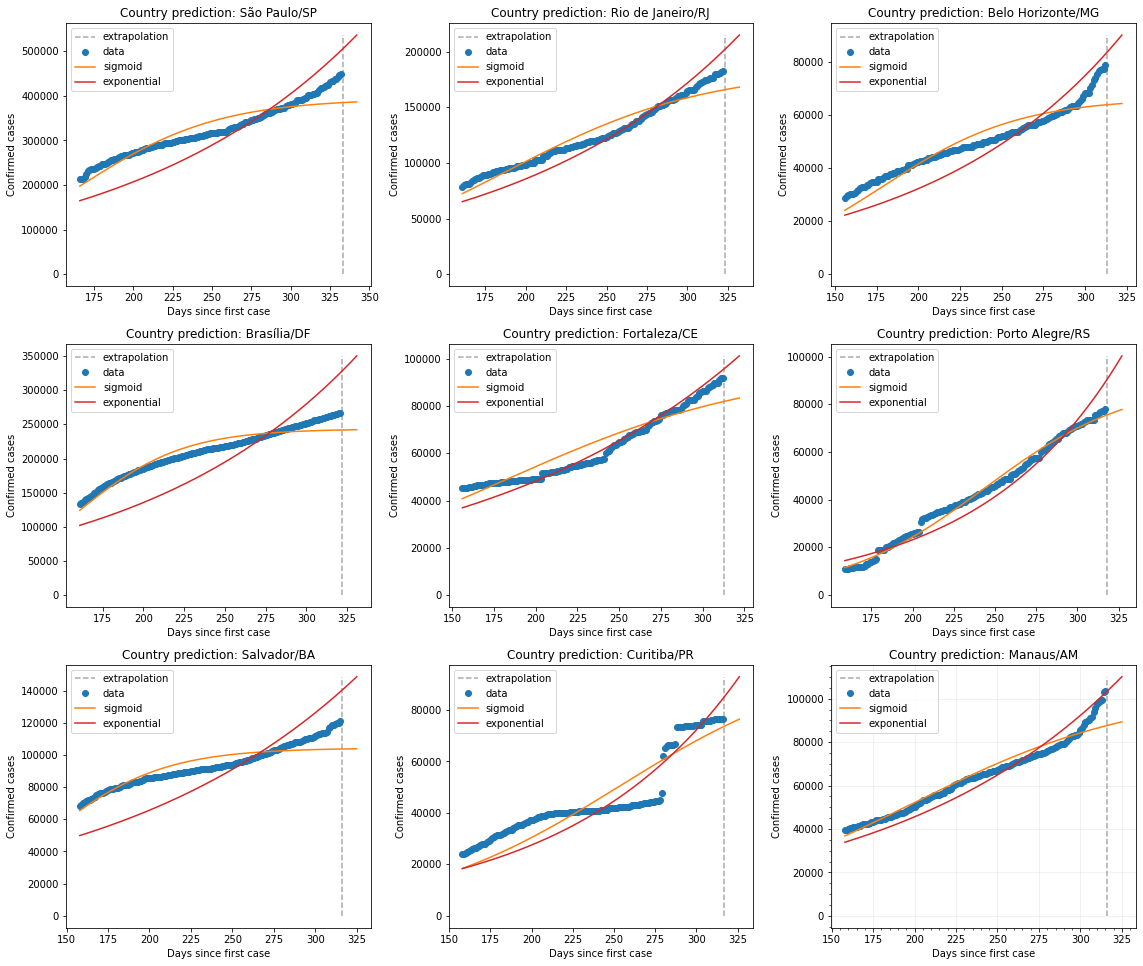

In [117]:
cities = (
    "São Paulo/SP", "Rio de Janeiro/RJ", "Belo Horizonte/MG",
    "Brasília/DF", "Fortaleza/CE", "Porto Alegre/RS",
    "Salvador/BA", "Curitiba/PR", "Manaus/AM"
)

data = []
for city in cities:
    dat = df_br_ct[df_br_ct["city"] == city]
    ydata = dat["totalCases"].to_numpy()
    data.append([city, [0] + list(ydata), 1, 1])
predict_curve(data, days=10)

---

Deaths in each capital are growing... let's visualize how deaths are spread across some cities.

In [118]:
df_br_deaths_city = pd.read_csv(f"data/covid-19/brazil/cases-brazil-cities-{data_atual}.csv")
df_br_deaths_city.rename(columns={"city": "City", "totalCases": "Total Cases", "deaths": "Deaths"}, inplace=True)
df_br_deaths_city["Mortality %"] = round((df_br_deaths_city["Deaths"] / df_br_deaths_city["Total Cases"]) * 100, 2)

main_cities = df_br_deaths_city[df_br_deaths_city["City"].isin(cities)]
print(main_cities[["City", "Total Cases", "Deaths", "Mortality %"]].sort_values(by=["Deaths"], ascending=False).to_string(index=False))

             City  Total Cases  Deaths  Mortality %
     São Paulo/SP       448744   16855         3.76
Rio de Janeiro/RJ       182713   16543         9.05
        Manaus/AM       103787    4502         4.34
      Brasília/DF       267340    4452         1.67
     Fortaleza/CE        91793    4262         4.64
      Salvador/BA       120897    3300         2.73
Belo Horizonte/MG        78822    2104         2.67
      Curitiba/PR        76530    2101         2.75
  Porto Alegre/RS        77924    2048         2.63


In [147]:
def print_graphic_for_brazil_city_death(df, cities, dtype="Normal"):
    fig = plt.figure(figsize=(14, 20))
    for i, city in enumerate(cities):
        ax = plt.subplot(5, 3, i + 1)
        data = df[df["City"] == city]
        skip = 30
        if dtype == "Normal":
            mortos = []
            for death in data["Deaths"]:
                mortos.append(abs(sum(mortos) - death))
            plt.title(f"# of people who died in {city}")
            plt.bar(data["date"].astype(str), mortos, color=f"C{i}")
            plt.xticks(np.arange(len(data["date"]), step=skip), data["date"][::skip])
        else:
            mortos = data["Mortality %"]
            plt.title(f"Mortality % for {city}")
            plt.plot(range(len(mortos)), mortos, "o", color="black")
            plt.fill_between(range(len(mortos)), mortos, color=f"C{i}")
            plt.xticks(np.arange(len(data["date"]), step=skip), data["date"][::skip])
        plt.xticks(rotation=45)
        plt.minorticks_on()
    plt.tight_layout()
    plt.show()

df_t_cities_br = []
days = get_day(range(1, 13))
for day in days:
    path = f"data/covid-19/brazil/cases-brazil-cities-{day}.csv"
    if os.path.isfile(path):
        cases_death = pd.read_csv(path)
        cases_death["date"] = day
        df_t_cities_br.append(cases_death)
cases_death_cities_brazil = pd.concat(df_t_cities_br, axis=0, ignore_index=True)
cases_death_cities_brazil.rename(columns={"city": "City", "totalCases": "Total Cases", "deaths": "Deaths"}, inplace=True)
cases_death_cities_brazil["Mortality %"] = round((cases_death_cities_brazil["Deaths"] / cases_death_cities_brazil["Total Cases"]) * 100, 2)
cases_death_cities_brazil = cases_death_cities_brazil.sort_values(by="date")

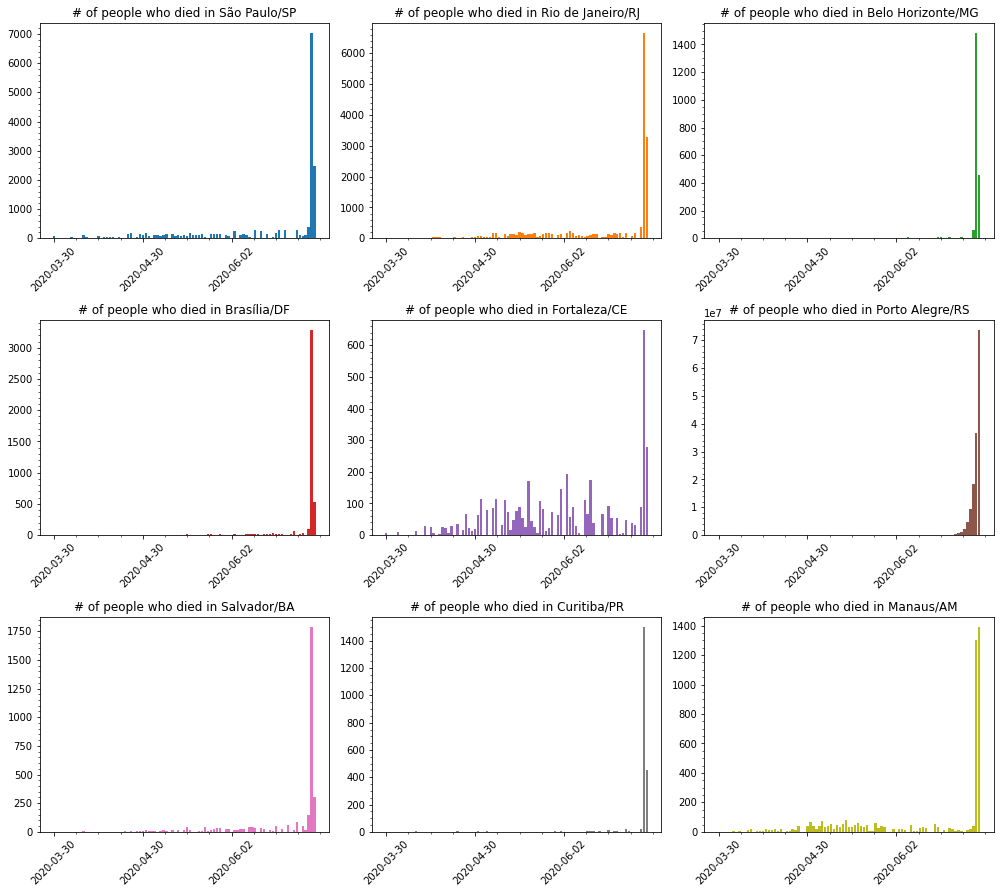

In [148]:
print_graphic_for_brazil_city_death(cases_death_cities_brazil, cities)

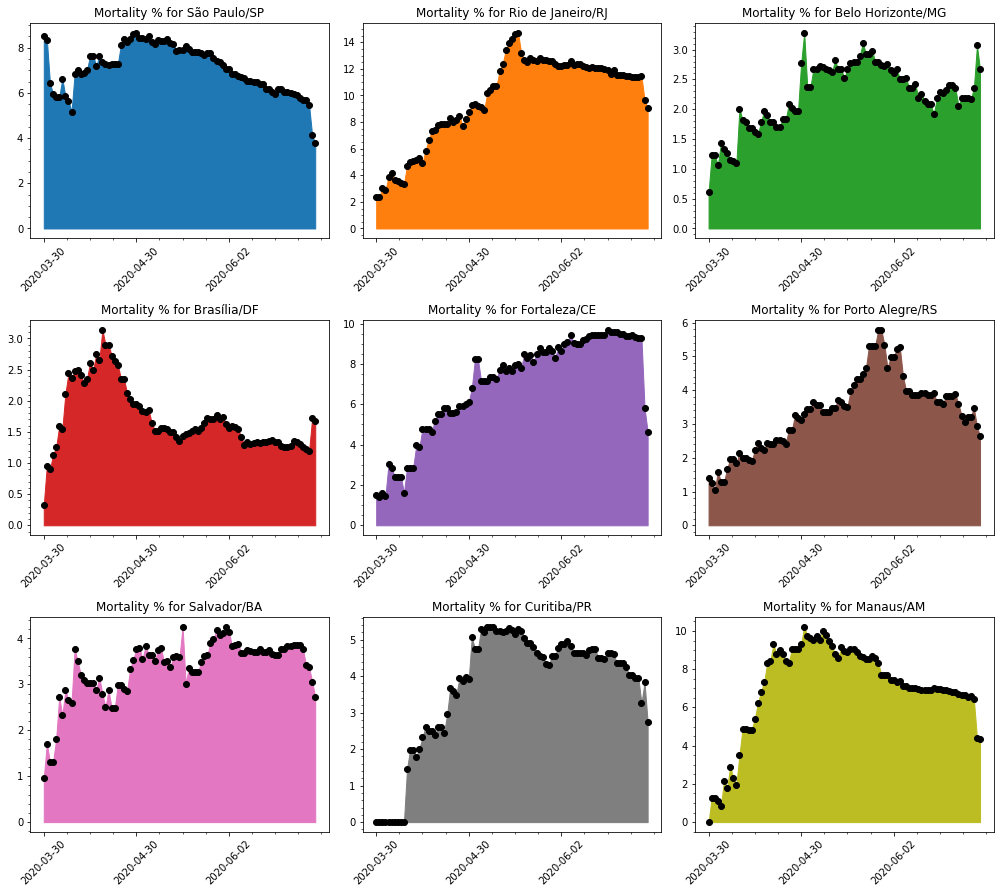

In [149]:
print_graphic_for_brazil_city_death(cases_death_cities_brazil, cities, dtype="Mortality")

Much has been talked about that people in Brazil are young, so there's little risk for the population... but if we take into account that Brazil population is one of the biggest in the world and calculating death or hospitalization based on data provided by Imperial College and China CDC, Brazil could have more than 50k deaths. This is a simplistic view... it should take into account comorbidities to calculate those numbers.

In [150]:
df_brazil_pop_age = pd.read_csv("data/brazil_pop_age.csv")
df_impact_cdc_china = pd.read_csv("data/impact/cdc_china.csv")
df_impact_imperial = pd.read_csv("data/impact/imperial_college.csv")

In [151]:
print("CDC China:")
print("-" * 20)
print(df_impact_cdc_china.to_string(index=False))

CDC China:
--------------------
Age (years)  Fatality Ratio %
        0-9               0.0
      10-19               0.2
      20-29               0.2
      30-39               0.2
      40-49               0.4
      50-59               1.3
      60-69               3.6
      70-79               8.0
         80              14.8


In [152]:
print("Imperial College:")
print("-" * 20)
print(df_impact_imperial.to_string(index=False))

Imperial College:
--------------------
Age (years)  % symptomatic cases (hospitalisation)  % hospitalised cases requiring critical care  Fatality Ratio %
        0-9                                    0.1                                           5.0             0.002
      10-19                                    0.3                                           5.0             0.006
      20-29                                    1.2                                           5.0             0.030
      30-39                                    3.2                                           5.0             0.080
      40-49                                    4.9                                           6.3             0.150
      50-59                                   10.2                                          12.2             0.600
      60-69                                   16.6                                          27.4             2.200
      70-79                              

---

Given the above values **(from Imperial College and CDC China)** lets do a **projection of the possible** # of deaths in each **Age** group and given a possible interval of deaths that may occur.

In [153]:
calculados = []
for i in range(9):
    idade = df_impact_imperial.loc[i]["Age (years)"]
    hospitalization = df_impact_imperial.loc[i]["% symptomatic cases (hospitalisation)"] / 100
    critical_care = df_impact_imperial.loc[i]["% hospitalised cases requiring critical care"] / 100
    fatal_ratio = df_impact_imperial.loc[i]["Fatality Ratio %"] / 100
    fatal_ratio_china = df_impact_cdc_china.loc[i]["Fatality Ratio %"] / 100
    
    pop = df_brazil_pop_age.loc[i*2:(i*2)+1]["brasil"].sum()
    
    hospitalizados = int(np.ceil(pop * hospitalization))
    precisando_cuidados = int(np.ceil(hospitalizados * critical_care))
    death_imperial = int(np.ceil(precisando_cuidados * fatal_ratio))
    death_china = int(np.ceil(precisando_cuidados * fatal_ratio_china))
    calculados.append((idade, pop, hospitalizados, precisando_cuidados, death_imperial, death_china))

colunas =[
    "Age", "Population", "# Hospitalization", 
    "# Critical Care", "# Deaths (Imperial College)", "# Deaths (China CDC)"
]
df_calculo_mortes_total = pd.DataFrame(calculados, columns=colunas)
print(df_calculo_mortes_total.to_string(index=False))

  Age  Population  # Hospitalization  # Critical Care  # Deaths (Imperial College)  # Deaths (China CDC)
  0-9    29340464              29341             1468                            1                     0
10-19    31089140              93268             4664                            1                    10
20-29    34324757             411898            20595                            7                    42
30-39    34130660            1092182            54610                           44                   110
40-49    28689589            1405790            88565                          133                   355
50-59    23477440            2394699           292154                         1753                  3799
60-69    16173590            2684816           735640                        16185                 26484
70-79     8654924            2103147           908560                        46337                 72685
   80     3492257             953387           675952  

In [154]:
percente_interval = 0.8

total_deaths_imperial = df_calculo_mortes_total["# Deaths (Imperial College)"].sum()
total_deaths_cdc_china = df_calculo_mortes_total["# Deaths (China CDC)"].sum()

calculated_deaths = []
for name, total_mean in [
    ("Imperial College", total_deaths_imperial), 
    ("CDC China", total_deaths_cdc_china), 
    ("Mean(Imperial + CDC China)", (total_deaths_imperial + total_deaths_cdc_china) / 2)
]:
    min_deaths = int(total_mean - (total_mean * percente_interval))
    max_deaths = int(total_mean + (total_mean * percente_interval))
    calculated_deaths.append((name, min_deaths, max_deaths))
calculated_deaths = pd.DataFrame(calculated_deaths, columns=["Name", "Min. Deaths", "Max. Deaths"])
print(calculated_deaths.to_string(index=False))

                      Name  Min. Deaths  Max. Deaths
          Imperial College        25465       229185
                 CDC China        40705       366346
Mean(Imperial + CDC China)        33085       297765


In [155]:
calc_deaths_range = []

mean_deaths_from_both_studies = (df_calculo_mortes_total["# Deaths (Imperial College)"] + df_calculo_mortes_total["# Deaths (China CDC)"]) / 2
for deaths in mean_deaths_from_both_studies:
    calc_deaths_range.append([
        int(deaths - (deaths * percente_interval)), 
        int(deaths + (deaths * percente_interval))
    ])
calc_deaths_range = np.asarray(calc_deaths_range)

df_calculo_mortes_total["Min. Deaths"] = calc_deaths_range[:, 0]
df_calculo_mortes_total["Max. Deaths"] = calc_deaths_range[:, 1]
df_calculo_mortes_total_n = df_calculo_mortes_total[["Age", "Min. Deaths", "Max. Deaths"]]
print(df_calculo_mortes_total_n.to_string(index=False))

  Age  Min. Deaths  Max. Deaths
  0-9            0            0
10-19            1            9
20-29            4           44
30-39           15          138
40-49           48          439
50-59          555         4996
60-69         4266        38402
70-79        11902       107119
   80        16290       146614


---


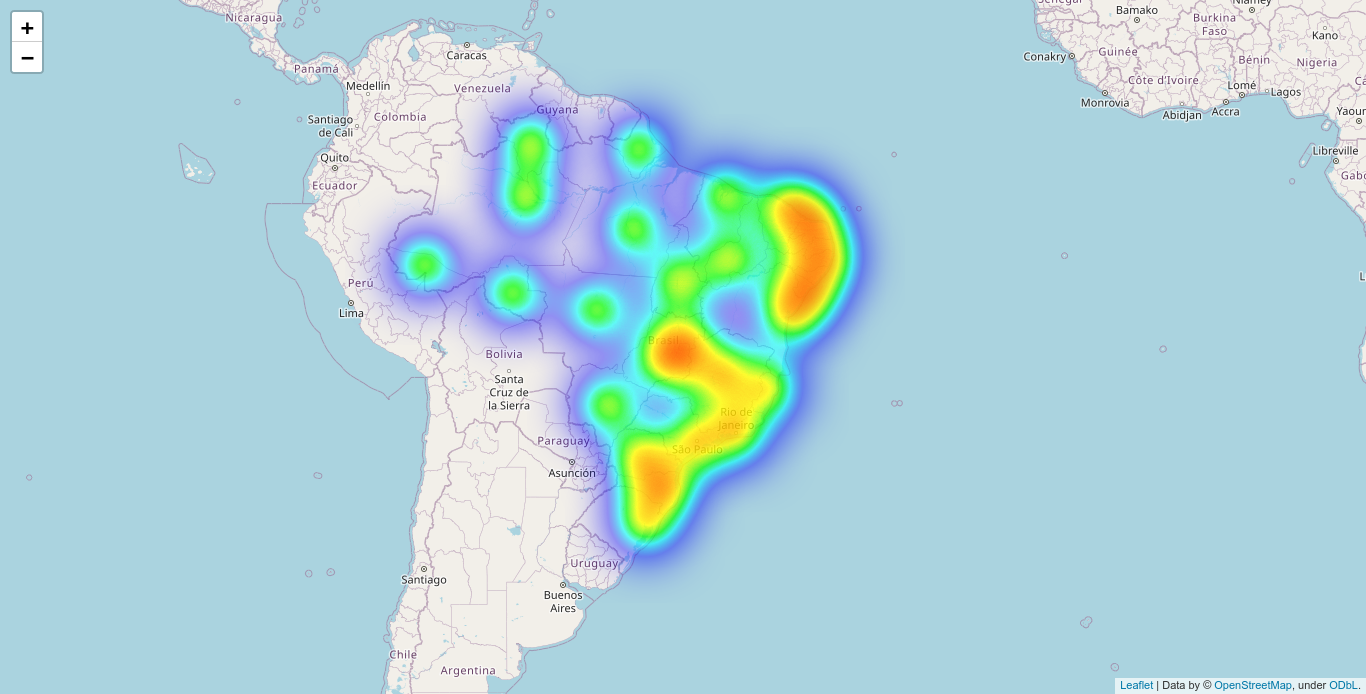

In [156]:
states = df_br[["State", "Latitude", "Longitude", "Total Cases"]]

heatmap_data = []
for idx, row in states.iterrows():
    lat, long, cases = row["Latitude"], row["Longitude"], row["Total Cases"]
    heatmap_data += [[lat, long, cases*12]]

m = folium.Map(location=(-15.77972, -47.92972), zoom_start=4.45)
heatmap = HeatMap(data=heatmap_data, min_opacity=0.7, radius=35, blur=45)
heatmap.add_to(m)
save_map_and_load(m, mapname="brazil_map")